# Прогнозирование изменения ставки ЦБ (Baseline-решение)

### Описание проекта:

Baseline-решение задачи классификации направления изменения будущей ключевой ставки ЦБ РФ по семантике текущего пресс-релиза, величины инфляции, курса доллара, а также текущей ставки ЦБ.

### Цели проекта:

Цель данной работы построение бейзлайна и его улучшение с помощью простейших моделей, для предсказания направления изменения ставки рефинансирования ЦБ. Это наша отправная точка для сравнения и улучшения. 

### План работы:

0. Общая предобработка данных.
1. Минимальный бейзлайн.
2. Статистические методы :
    - Мешок слов плюс линейная модель
    - TF-IDF плюс линейная модель
    - N-граммы плюс Naive Bayes
3. Создание эмбеддингов:
    - Word2Vec плюс линейная модель
    - GloVe плюс линейная модель
4. Выводы

### Описание данных:

- `date` - дата публикации пресс-релиза
- `title` - заголовок пресс-релиза
- `release` - текст пресс-релиза
- `inflation` - годовая инфляция
- `rate` - величина ключевой ставки ЦБ, объявленная на следущем заседании
- `usd` - курс доллара
- `usd_cur_change_relative` - относительное изменение курса доллара, по сравнению с предыдущим заседанием
- `target_categorial` - категориальная метка направления изменения ключевой ставки ЦБ, 1 - повышение, -1 - понижение, 0 - без изменений.
- `target_absolute` - абсолютное изменение ключевой ставки ЦБ (следующее значение минус текущее)
- `target_relative` - относительное изменение ключевой ставки ЦБ (следующее значение делится на текущее)

In [1]:
import re
from string import punctuation

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
import gensim.downloader as api
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pymystem3 import Mystem
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

RANDOM_STATE = 41825352
DATASET_URL = '../data/cbr-press-releases.csv'

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/father/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/father/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/father/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Загрузим датасет пресс-релизов, полученных с сайта ЦБ РФ:

In [2]:
df = pd.read_csv(DATASET_URL, parse_dates=['date'])

## Общая предобработка данных

`rate` - величина ключевой ставки, которую объявят на следующем заседании. Мы хотели бы знать эту величину. Но мы знаем текущую ставку и эту информацию можно добавить в наши данные сдвинув ставку на один.

In [3]:
df['rate'] = df.rate.shift(1)

В сентябре 2013 года ЦБ ввел ключевую ставку, и назначил ее величину в 5,5% заполним пропущенное значение.

In [4]:
df.loc[0, 'rate'] = 5.5

Дату сделаем индексом, ссылку на пресс-релиз выбросим, эта переменная не поможет в предсказании таргета.

In [5]:
df.set_index('date', inplace=True)
df.drop('link', axis=1, inplace=True)

Для последнего релиза неизвестна целевая переменная (направление изменения ключевой ставки), поэтому исключим его из датасета и сохраним отдельно:

In [6]:
df.sort_values('date', inplace=True)
cur_pr = df.tail(1)
df = df[:-1]

Мы хотим предсказывать направление ставки рефинансирования `target_categorial`, выделим ее как целевую переменную. `target_absolute` и `target_relative` содержит в себе информацию о целевой переменной удалим их из матрицы признаков.

In [7]:
X = df.drop(['target_categorial', 'target_absolute', 'target_relative'], axis=1)
y = df['target_categorial']

## Минимальный безлайн 

Направление изменения ставки будем предсказывать таким, как в последнем решении. До 13 сентября ключевой ставки не существовало, поэтому мы не можем предсказать таким способом для первого наблюдения, будем оценивать качество бейзлайна без него.

In [8]:
y_pred = y.shift(1)
accuracy = accuracy_score(y[1:], y_pred[1:])
f1 = f1_score(y[1:], y_pred[1:], average='macro')
precision = precision_score(y[1:], y_pred[1:], average='macro')
recall = recall_score(y[1:], y_pred[1:], average='macro')
min_baseline = pd.DataFrame({'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}, index=['min_baseline'])

## Статистические методы

### Мешок слов плюс линейная модель

Создадим функцию для тестирования наших моделей. Зададим начальный порог и будем обучать, модель на наблюдениях до порога, а тестировать на одном наблюдении после. Двигая порог протестируем нашу модель. И потом сравним с истинными ответами. Качество всех наших моделей будем записывать в табличку.

In [ ]:
def calc_metrics(X, model, *, name, plot=True, **params):
    y_preds = []
    y_preds_proba = []
    model = model(**params)
    for threshold in range(30, 96):
        X_train = X[:threshold]
        X_test = X[threshold:]
        y_train = y[:threshold]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test[0].reshape(1, -1))
        y_pred_proba = model.predict_proba(X_test[0].reshape(1, -1))
        y_preds.append(y_pred.item())
        y_preds_proba.append(y_pred_proba)

    acc = accuracy_score(y[30:], y_preds)
    f1 = f1_score(y[30:], y_preds, average='macro')
    recall = recall_score(y[30:], y_preds, average='macro')
    precision = precision_score(y[30:], y_preds, average='macro')
    roc_auc = roc_auc_score(y[30:], np.concatenate(y_preds_proba, axis=0), average='macro', multi_class='ovr')
    if plot:
        print(classification_report(y[30:], y_preds))
        cm = confusion_matrix(y[30:], y_preds)
        cm = pd.DataFrame(cm, index=['-1', '0', '1'], columns=['-1', '0', 1])
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title("Confusion matrix")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        metrics = pd.DataFrame({
            'accuracy': acc, 'f1': f1, 'recall': recall, 'precision': precision, 'roc_auc_ovr': roc_auc,
            }, index=[name])
        return metrics, model
    else:
        return roc_auc.item(), model

Обучим логистическую регрессию с l1 регуляризацией, она нам покажет какие слова не влияют на предсказание модели.

In [10]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

bow = vectorizer.transform(X.release)

In [ ]:
auc = []
for c in tqdm(np.linspace(0.001, 10, 30)):
    auc.append(calc_metrics(bow, LogisticRegression, name='bow l1 only release', plot=False, solver='liblinear', penalty='l1', C=c.item()))

roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/30 [00:00<?, ?it/s]/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 30/30 [00:12<00:00,  2.37it/s]

Лучшая модель - LogisticRegression(C=5.517689655172415, penalty='l1', solver='liblinear')
ROC-AUC = 0.7686129373702335


Рассмотрим подробнее лучшую модель.

              precision    recall  f1-score   support

        -1.0       0.68      0.65      0.67        23
         0.0       0.50      0.58      0.54        24
         1.0       0.75      0.63      0.69        19

    accuracy                           0.62        66
   macro avg       0.64      0.62      0.63        66
weighted avg       0.64      0.62      0.63        66



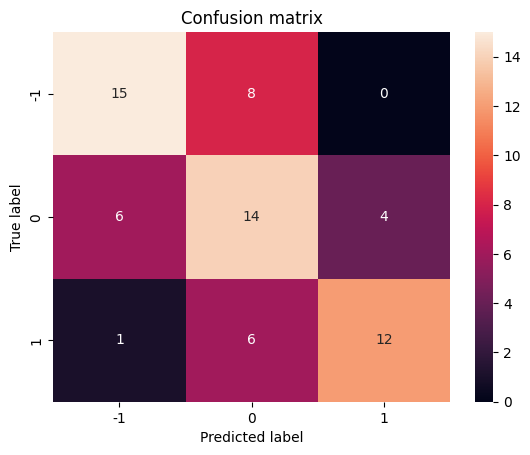

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039


In [ ]:
metric, model = calc_metrics(bow, LogisticRegression, name='bow l1 only release', **best_model.get_params())
metrics = pd.concat([min_baseline, metric], axis=0)
metrics

Качество даже хуже минимального бейзлайна, подберем гиперпараметры для elasticnet, и только на тех словах, веса при которых не занулила прошлая модель. Мы таким образом заглянем в тестовую выборку, но скорее всего это будет не критично. Таким образом расширим множество стоп слов, словами которые не важны для прошлой модели.

In [13]:
STOP_WORDS |= set(vectorizer.get_feature_names_out()[np.all(model.coef_ == 0, axis=0)])

In [14]:
vectorizer = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

bow = vectorizer.transform(X.release)

In [ ]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(bow, 
                                LogisticRegression,
                                name='bow l2', 
                                plot=False, 
                                solver='saga', 
                                penalty='elasticnet', 
                                C=c, 
                                max_iter=10000, 
                                # n_jobs=-1,
                                l1_ratio=l1_ratio
                                )
                            )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 4/4 [01:50<00:00, 27.59s/it]

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.8726695205380253


Обучим лучшую модель и посмотрим ее оценки качества подробнее.

              precision    recall  f1-score   support

        -1.0       0.83      0.83      0.83        23
         0.0       0.63      0.71      0.67        24
         1.0       0.75      0.63      0.69        19

    accuracy                           0.73        66
   macro avg       0.74      0.72      0.73        66
weighted avg       0.73      0.73      0.73        66



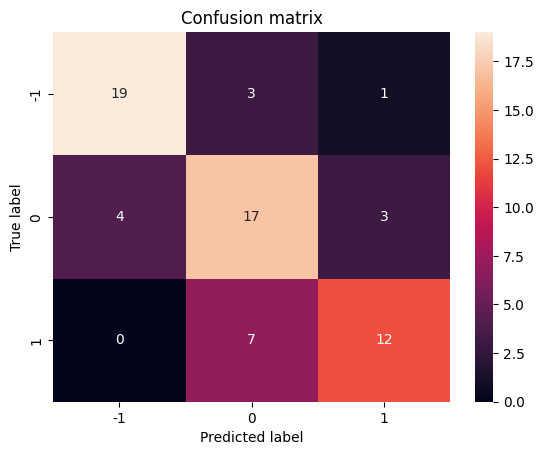

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039
bow elasticnet,0.727273,0.726156,0.735239,0.722000,0.872670


In [ ]:
metric, _ = calc_metrics(bow, LogisticRegression, name='bow elasticnet', **best_model.get_params())
metrics = pd.concat((metrics, metric))
metrics

Качество немного подросло попробуем обучить мешок слов не только на пресс-релизах, но и на названиях.

In [17]:
vectorizer_title = CountVectorizer(
    preprocessor=preprocessor,
)

vectorizer_title.fit(X.title)

bow_title = vectorizer_title.transform(X.title)

In [18]:
bow_title_release = np.concatenate((bow.toarray(), bow_title.toarray()), axis=1)

Подберем гиперпараметры для модели обучаемой на названии релиза и самом релизе.

In [ ]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(bow_title_release,
                               LogisticRegression, 
                                name='bow', 
                                plot=False, 
                                solver='saga', 
                                penalty='elasticnet', 
                                C=c, 
                                max_iter=10000, 
                                # n_jobs=-1,
                                l1_ratio=l1_ratio
                            )
                        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 4/4 [01:49<00:00, 27.34s/it]

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.8719655590977817


Посмотрим на метрики модели и добавим их в таблицу.

              precision    recall  f1-score   support

        -1.0       0.83      0.83      0.83        23
         0.0       0.63      0.71      0.67        24
         1.0       0.75      0.63      0.69        19

    accuracy                           0.73        66
   macro avg       0.74      0.72      0.73        66
weighted avg       0.73      0.73      0.73        66



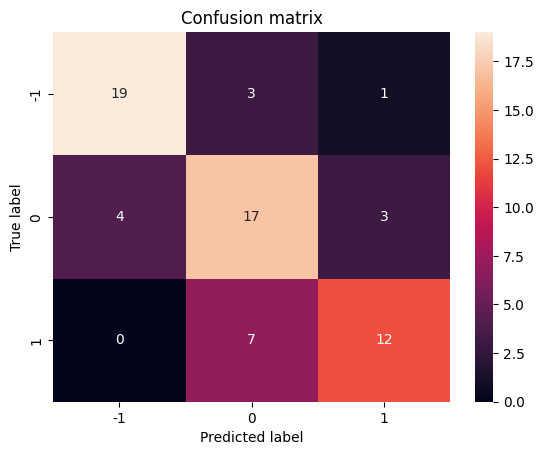

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039
bow elasticnet,0.727273,0.726156,0.735239,0.722000,0.872670
bow release title,0.727273,0.726156,0.735239,0.722000,0.870925


In [ ]:
metric, _ = calc_metrics(bow_title_release, LogisticRegression, name='bow release title', **best_model.get_params())
metrics = pd.concat([metrics, metric])
metrics

Добавление мешка слов по названию не улучшило нашу модель, а только усложнило ее. Попробуем к мешку слов по текстам релизов, с самыми важными словами добавим количественные признаки.

In [21]:
num_columns = ['inflation', 'rate', 'usd', 'usd_cur_change_relative']

scaler = StandardScaler()
scaler.fit(X[num_columns])
X[num_columns] = scaler.transform(X[num_columns])

In [22]:
all_data = np.concatenate((bow_title_release, X[num_columns].values), axis=1)

In [ ]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(all_data, 
                               LogisticRegression,
                            name='bow all data', 
                            plot=False, 
                            solver='saga', 
                            penalty='elasticnet', 
                            C=c, 
                            max_iter=10000, 
                            # n_jobs=-1,
                            l1_ratio=l1_ratio
                            )
                        )
    
roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 4/4 [01:48<00:00, 27.20s/it]

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.8659324746590521


              precision    recall  f1-score   support

        -1.0       0.80      0.87      0.83        23
         0.0       0.64      0.67      0.65        24
         1.0       0.75      0.63      0.69        19

    accuracy                           0.73        66
   macro avg       0.73      0.72      0.72        66
weighted avg       0.73      0.73      0.73        66



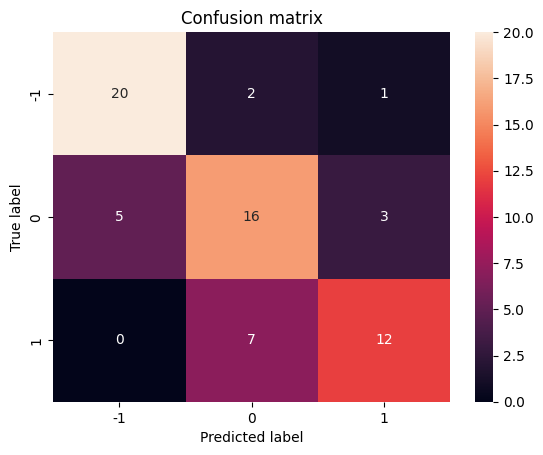

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039
bow elasticnet,0.727273,0.726156,0.735239,0.722000,0.872670
bow release title,0.727273,0.726156,0.735239,0.722000,0.870925
bow release all num,0.727273,0.724036,0.730000,0.722604,0.865277


In [ ]:
metric, _ = calc_metrics(all_data, LogisticRegression, name='bow release all num', **best_model.get_params())

metrics = pd.concat([metrics, metric])
metrics

Добавление количественных переменных только ухудшило нашу модель.

### Tf-idf и линейная модель

Протестируем TF-IDF на текстах релизов.

In [25]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

tf_idf = vectorizer.transform(X.release)

In [ ]:
auc = []
for c in tqdm(np.linspace(0.001, 10, 30)):
    auc.append(calc_metrics(tf_idf, LogisticRegression, name='tf-idf l1 only release', plot=False, solver='liblinear', penalty='l1', C=c.item()))

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/30 [00:00<?, ?it/s]/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  7%|▋         | 2/30 [00:00<00:02, 10.88it/s]/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 

Лучшая модель - LogisticRegression(C=10.0, penalty='l1', solver='liblinear')
ROC-AUC = 0.784512791251531


              precision    recall  f1-score   support

        -1.0       0.70      0.70      0.70        23
         0.0       0.47      0.58      0.52        24
         1.0       0.77      0.53      0.62        19

    accuracy                           0.61        66
   macro avg       0.64      0.60      0.61        66
weighted avg       0.63      0.61      0.61        66



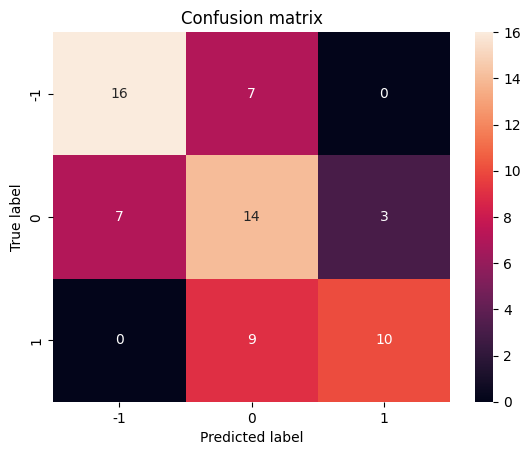

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039
bow elasticnet,0.727273,0.726156,0.735239,0.722000,0.872670
bow release title,0.727273,0.726156,0.735239,0.722000,0.870925
bow release all num,0.727273,0.724036,0.730000,0.722604,0.865277
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513


In [ ]:
metric, model = calc_metrics(tf_idf, LogisticRegression, name='tf_idf l1 only release', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

In [28]:
STOP_WORDS |= set(vectorizer.get_feature_names_out()[np.all(model.coef_ == 0, axis=0)])

In [29]:
vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

tf_idf = vectorizer.transform(X.release)

In [ ]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(tf_idf, 
                               LogisticRegression,
                            name='tf-idf', 
                            plot=False, 
                            solver='saga', 
                            penalty='elasticnet', 
                            C=c, 
                            max_iter=10000, 
                            # n_jobs=-1,
                            l1_ratio=l1_ratio
                            )
                        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/4 [00:00<?, ?it/s]/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 4/4 [00:17<00:00,  4.43s/it]

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.900986562293837


              precision    recall  f1-score   support

        -1.0       0.82      0.78      0.80        23
         0.0       0.67      0.75      0.71        24
         1.0       0.82      0.74      0.78        19

    accuracy                           0.76        66
   macro avg       0.77      0.76      0.76        66
weighted avg       0.76      0.76      0.76        66



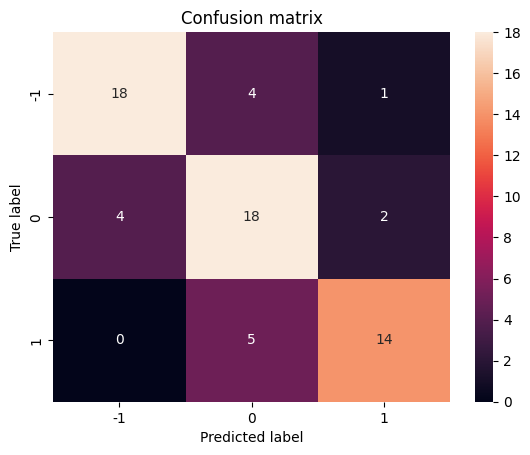

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039
bow elasticnet,0.727273,0.726156,0.735239,0.722000,0.872670
bow release title,0.727273,0.726156,0.735239,0.722000,0.870925
bow release all num,0.727273,0.724036,0.730000,0.722604,0.865277
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901612


In [ ]:
metric, model = calc_metrics(tf_idf, LogisticRegression, name='tf_idf only release best word', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество еще немного подросло. Как и в случае с мешком слов попробуем обучить tf-idf на названиях и добавим эти переменые в матрицу объект-признак.

In [32]:
vectorizer_title = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer_title.fit(X.title)

tf_idf_title = vectorizer_title.transform(X.title)

In [33]:
tf_idf_title_release = np.concatenate((tf_idf.toarray(), tf_idf_title.toarray()), axis=1)

In [ ]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(tf_idf_title_release, 
                               LogisticRegression,
                                name='tf-idf', 
                                plot=False, 
                                solver='saga', 
                                penalty='elasticnet', 
                                C=c, 
                                max_iter=10000, 
                                # n_jobs=-1,
                                l1_ratio=l1_ratio
                            )
                        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/4 [00:00<?, ?it/s]/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.8787469513247727


              precision    recall  f1-score   support

        -1.0       0.80      0.70      0.74        23
         0.0       0.60      0.75      0.67        24
         1.0       0.81      0.68      0.74        19

    accuracy                           0.71        66
   macro avg       0.74      0.71      0.72        66
weighted avg       0.73      0.71      0.72        66



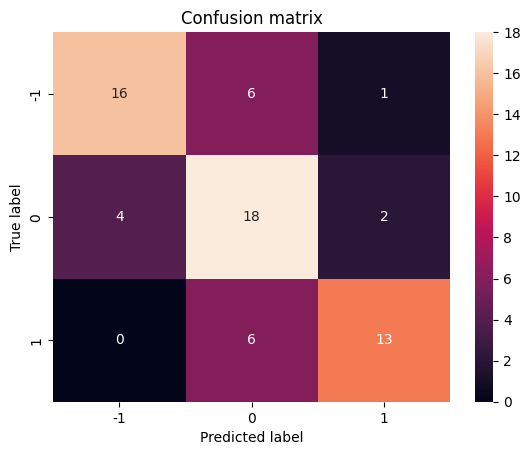

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039
bow elasticnet,0.727273,0.726156,0.735239,0.722000,0.872670
bow release title,0.727273,0.726156,0.735239,0.722000,0.870925
bow release all num,0.727273,0.724036,0.730000,0.722604,0.865277
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901612
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747


In [ ]:
metric, model = calc_metrics(tf_idf_title_release, LogisticRegression, name='tf_idf title release', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

При добавлении названия, качество модели заметно ухудшается, возможно эти признаки приводят к переобучению. Попробуем добавить количественные переменные.

In [36]:
tf_idf_num = np.concatenate((tf_idf.toarray(), X[num_columns].values), axis=1)

In [ ]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(tf_idf_num, 
                               LogisticRegression,
                                name='tf-idf', 
                                plot=False, 
                                solver='saga', 
                                penalty='elasticnet', 
                                C=c, 
                                max_iter=10000, 
                                # n_jobs=-1,
                                l1_ratio=l1_ratio
                            )
                        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/4 [00:00<?, ?it/s]/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.8358718748504713


              precision    recall  f1-score   support

        -1.0       0.78      0.61      0.68        23
         0.0       0.56      0.79      0.66        24
         1.0       0.86      0.63      0.73        19

    accuracy                           0.68        66
   macro avg       0.73      0.68      0.69        66
weighted avg       0.72      0.68      0.69        66



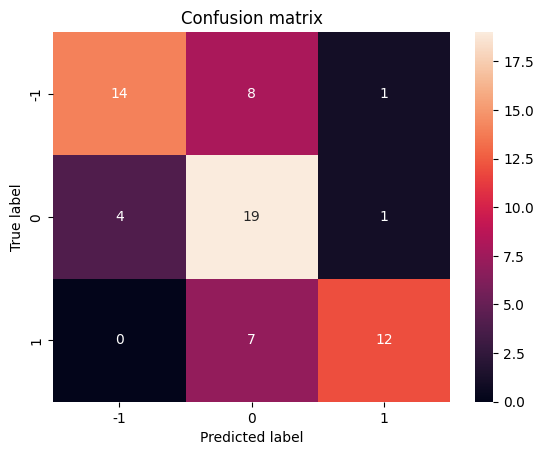

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039
bow elasticnet,0.727273,0.726156,0.735239,0.722000,0.872670
bow release title,0.727273,0.726156,0.735239,0.722000,0.870925
bow release all num,0.727273,0.724036,0.730000,0.722604,0.865277
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901612
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872


In [ ]:
metric, model = calc_metrics(tf_idf_num, LogisticRegression, name='tf_idf numerical release', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Добавление цифр из наших данных только ухудшило нашу модель.

### N-граммы плюс Naive Bayes

In [39]:
# сохраним стоп слова которые мы использовали в лучшей модели на tf-idf матрице
STOP_WORDS_TF_IDF = STOP_WORDS

Попробуем решить задачу с помощью алгоритма Naive Bayes, подберем оптимальные значения для параметра `ngram_range` и обучим лучшую модель.

In [40]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

In [ ]:
auc = []
for start in tqdm(range(1, 10)):
    for stop in range(start, min(10, start + 4)):
        vectorizer = CountVectorizer(
            preprocessor=preprocessor,
            ngram_range=(start, stop)
        )
        bow_ngram = vectorizer.fit_transform(X.release)
        auc.append(
            (calc_metrics(
                bow_ngram, 
                MultinomialNB, 
                name='MultinomialNB',
                plot=False
            ), 
            (start, stop)),
        )
    
(roc_auc, best_model), (start, stop) = max(auc, key=lambda x: x[0][0])

print(f"Лучшая модель - ngram_range({start}, {stop})")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 9/9 [00:42<00:00,  4.69s/it]

Лучшая модель - ngram_range(3, 6)
ROC-AUC = 0.7729945341838965


In [42]:
vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    ngram_range=(start, stop)
)

vectorizer.fit(X.release)

bow_ngram = vectorizer.transform(X.release)

              precision    recall  f1-score   support

        -1.0       0.68      0.83      0.75        23
         0.0       0.56      0.42      0.48        24
         1.0       0.65      0.68      0.67        19

    accuracy                           0.64        66
   macro avg       0.63      0.64      0.63        66
weighted avg       0.63      0.64      0.62        66



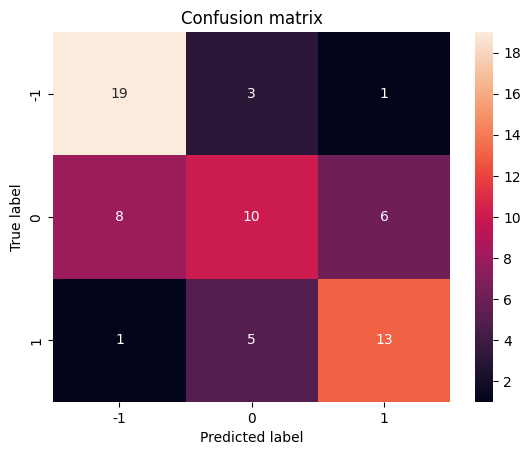

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039
bow elasticnet,0.727273,0.726156,0.735239,0.722000,0.872670
bow release title,0.727273,0.726156,0.735239,0.722000,0.870925
bow release all num,0.727273,0.724036,0.730000,0.722604,0.865277
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901612
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872
MultinomialNB,0.636364,0.629318,0.628042,0.642321,0.772995


In [ ]:
metric, model = calc_metrics(bow_ngram, MultinomialNB, name='MultinomialNB')
metrics = pd.concat((metrics, metric))
metrics

Получили качество даже хуже чем минимальный безлайн.

## Создание эмбеддингов

### Word2Vec плюс линейная модель

Обучим `Word2Vec` на текстах наших данных, а представлением текста релиза будем считать сумму, представлений всех его слов.

In [ ]:

texts = X.release.map(preprocessor).str.split()

best_models = {'window': [], 'roc_auc': [], 'model': []}
for window in tqdm(range(3, 20, 2)):
    model = Word2Vec(
        sentences=texts, 
        window=window,
        min_count=10, 
        vector_size=92,
        sg=1,
        epochs=100
        )

    embedings = texts.map(lambda x: [model.wv[word] for word in x if word in model.wv])
    embedings = embedings.map(lambda x: np.array(x).sum(0))
    embedings_w2v = np.array([arr.tolist() for arr in embedings])

    roc_auc, best_model = calc_metrics(
            embedings_w2v, 
            LogisticRegression,
            name='embedings_w2v', 
            plot=False, 
            solver='saga', 
            penalty='elasticnet', 
            max_iter=10000, 
            # n_jobs=-1,
            l1_ratio=0.5
        )
        
    best_models['window'].append(window)
    best_models['roc_auc'].append(roc_auc)
    best_models['model'].append(best_model)

100%|██████████| 9/9 [04:18<00:00, 28.71s/it]


Посмотрим как меняется качество модели при изменении размера окна.

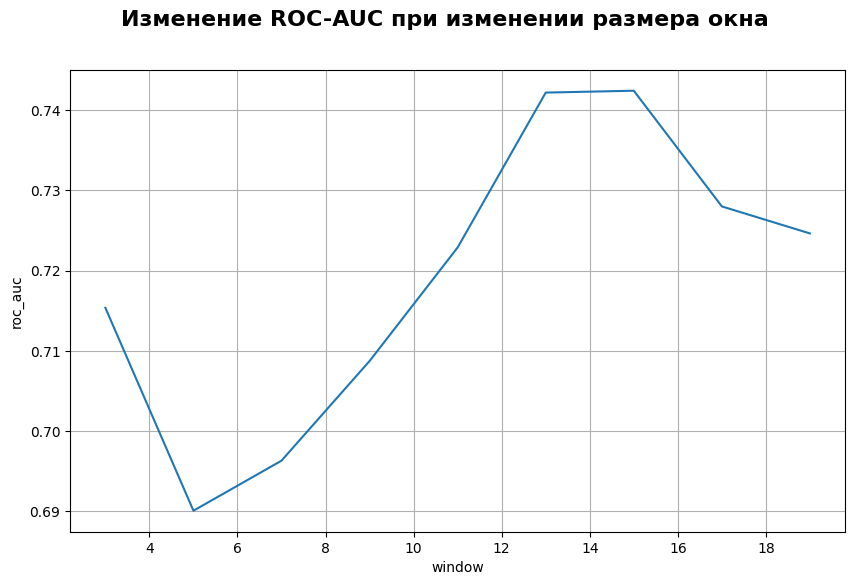

In [45]:
plt.figure(figsize=(10, 6))
data = pd.DataFrame(best_models)
sns.lineplot(x='window', y='roc_auc', data=data)
plt.suptitle("Изменение ROC-AUC при изменении размера окна", weight='bold', fontsize=16)
plt.grid()
plt.show()

При увеличении размера окна до 15 качество растет, а после 15 начинает снижаться. Обучим Word2vec c размером окна 15 подберем оптимальные параметры логистической регрессии и оценим качество модели.

In [ ]:
w2v = Word2Vec(
        sentences=texts, 
        window=15,
        min_count=10, 
        vector_size=92,
        sg=1,
        epochs=100
        )

embedings = texts.map(lambda x: [w2v.wv[word] for word in x if word in w2v.wv])
embedings = embedings.map(lambda x: np.array(x).sum(0))
embedings_w2v = np.array([arr.tolist() for arr in embedings])

auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                embedings_w2v, 
                LogisticRegression,
                name='tf-idf', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                # n_jobs=-1,
                l1_ratio=l1_ratio
            )
        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 4/4 [03:13<00:00, 48.48s/it]

Лучшая модель - LogisticRegression(C=5, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.7280702136304411


Посмотрим на метрики модели подробнее

              precision    recall  f1-score   support

        -1.0       0.65      0.65      0.65        23
         0.0       0.48      0.50      0.49        24
         1.0       0.61      0.58      0.59        19

    accuracy                           0.58        66
   macro avg       0.58      0.58      0.58        66
weighted avg       0.58      0.58      0.58        66



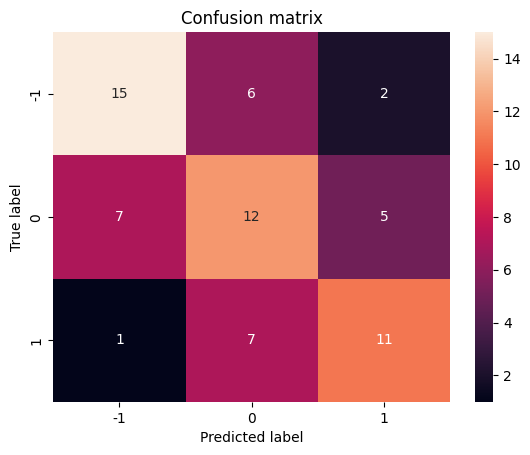

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039
bow elasticnet,0.727273,0.726156,0.735239,0.722000,0.872670
bow release title,0.727273,0.726156,0.735239,0.722000,0.870925
bow release all num,0.727273,0.724036,0.730000,0.722604,0.865277
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901612
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872
MultinomialNB,0.636364,0.629318,0.628042,0.642321,0.772995


In [ ]:
metric, model = calc_metrics(embedings_w2v, LogisticRegression, name='word2vec', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество получили хуже чем минимальный бейзлайн, потому что `word2vec` неплохо создает представления слов, но в сумме этих представлений плохо сохраняется смысл всего текста. Попробуем уже обученную модель `word2vec`. Скачаем `word2vec-ruscorpora-300` обученную на русских текстах.

In [48]:
w2v_ruscorpora = api.load('word2vec-ruscorpora-300')

# функция для добавления части речи к словам
def tag(words):
    morph = MorphAnalyzer()
    # tagged = str(morph.parse(word)[0].tag.POS)
    # return word + '_' + tagged
    parts = [str(morph.parse(word)[0].tag.POS) for word in words]
    return [word + '_' + part for word, part in zip(words, parts)]

In [49]:
embedings_ruscorpora = texts.map(tag).map(lambda x: [w2v_ruscorpora[word] for word in x if word in w2v_ruscorpora])
embedings_ruscorpora = embedings_ruscorpora.map(lambda x: np.array(x).sum(0))
embedings_ruscorpora = np.array([arr.tolist() for arr in embedings_ruscorpora])

In [ ]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                embedings_ruscorpora, 
                LogisticRegression,
                name='pretrained_word2vec', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                # n_jobs=-1,
                l1_ratio=l1_ratio
            )
        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

100%|██████████| 4/4 [10:08<00:00, 152.01s/it]

Лучшая модель - LogisticRegression(C=0.1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.7606292512727605


Оценим качество модели подробнее.

              precision    recall  f1-score   support

        -1.0       0.65      0.65      0.65        23
         0.0       0.45      0.54      0.49        24
         1.0       0.79      0.58      0.67        19

    accuracy                           0.59        66
   macro avg       0.63      0.59      0.60        66
weighted avg       0.62      0.59      0.60        66



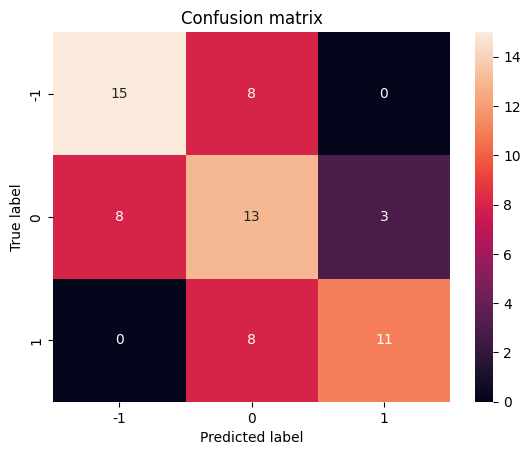

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.630281,0.643939,0.622362,0.764039
bow elasticnet,0.727273,0.726156,0.735239,0.722000,0.872670
bow release title,0.727273,0.726156,0.735239,0.722000,0.870925
bow release all num,0.727273,0.724036,0.730000,0.722604,0.865277
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901612
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872
MultinomialNB,0.636364,0.629318,0.628042,0.642321,0.772995


In [ ]:
metric, model = calc_metrics(embedings_ruscorpora, LogisticRegression, name='word2vec_pretrained', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество практически не изменилось по сравнению с прошлой моделью. Попробуем считать сумму ембедингов без слов, которые мы считали стоп словами в модели tf-idf.

In [52]:
def tag(words):
    morph = MorphAnalyzer()
    # tagged = str(morph.parse(word)[0].tag.POS)
    # return word + '_' + tagged
    parts = [str(morph.parse(word)[0].tag.POS) for word in words if word not in STOP_WORDS_TF_IDF]
    return [word + '_' + part for word, part in zip(words, parts)]

In [53]:
embedings_ruscorpora_stop_words = texts.map(tag).map(lambda x: [w2v_ruscorpora[word] for word in x if word in w2v_ruscorpora])
embedings_ruscorpora_stop_words = embedings_ruscorpora_stop_words .map(lambda x: np.array(x).sum(0))
embedings_ruscorpora_stop_words  = np.array([arr.tolist() for arr in embedings_ruscorpora_stop_words ])

In [ ]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                embedings_ruscorpora_stop_words, 
                LogisticRegression,
                name='pretrained_word2vec', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                # n_jobs=-1,
                l1_ratio=l1_ratio
            )
        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/4 [00:00<?, ?it/s]/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/father/Desktop/cbr-press-release-classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 4/4 [06:08<00:00, 92.03s/it] 

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.6936526548666867


Качество получилось совсем плохое, не будем заносить ее заносить в общую табличку.